In [0]:
from __future__ import print_function

In [0]:
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import spacy
import operator

In [0]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

In [0]:
train = pd.read_csv("clean_train.csv")
test = pd.read_csv("clean_test.csv")

In [0]:
train.head(5)

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
0,0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0,163,0,0.000000,27,27,1.000000
1,1,000103f0d9cfb60f,d aww ! match background colour i be seemingly...,0,0,0,0,0,0,146,0,0.000000,30,23,0.766667
2,2,000113f07ec002fd,hey man i be really try edit war guy constantl...,0,0,0,0,0,0,136,0,0.000000,23,22,0.956522
3,3,0001b41b1c6bb37e,can not make real suggestion improvement - wo...,0,0,0,0,0,0,387,0,0.000000,61,52,0.852459
4,4,0001d958c54c6e35,-PRON- sir hero chance remember page that on ?,0,0,0,0,0,0,47,4,0.085106,9,9,1.000000


## Data preprocessing


In [0]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [0]:
new_features = ['Unnamed: 0', 'total_length', 'capitals', 'caps_vs_length', 'num_words', 'num_unique_words', 'words_vs_unique']
df_toxic1 = train.drop(['id', 'comment_text'], axis=1)
df_toxic = df_toxic1.drop(new_features, axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5,0,'# of categories')

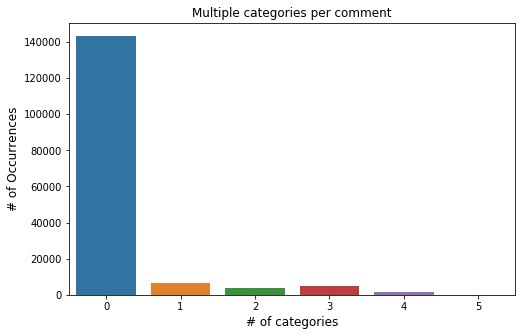

In [0]:
rowsums = train.iloc[:,3:8].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [0]:
# get the index of comments with/without label
no_label_ind = train[train['toxic']+train['severe_toxic'] + train['obscene']+ train['threat'] + train['identity_hate'] == 0 ].index
with_label_ind = train[train['toxic']+train['severe_toxic'] + train['obscene']+ train['threat'] + train['identity_hate'] > 0 ].index

In [0]:
Not_labeld_comment = len(no_label_ind)
Not_labeld_comment

143647

In [0]:
labeld_comment = len(with_label_ind)
labeld_comment

15924

In [0]:
# random sample the with no label indices based on the amount of labeled samples
new_not_labeld_comment_ind = np.random.choice(no_label_ind, labeld_comment, replace = True)
# merge the two indices together
undersample_ind = np.concatenate([new_not_labeld_comment_ind, with_label_ind])
# get undersampled dataframe from the merged indices
undersampled_data = train.loc[undersample_ind]

In [0]:
undersampled_data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
35897,35897,5fe87f7610c13511,take care -PRON- worry,0,0,0,0,0,0,23,4,0.173913,4,4,1.000000
120035,120035,81ef70277d2b8279,episode list layout think episode list look l...,0,0,0,0,0,0,130,0,0.000000,21,18,0.857143
30402,30402,50b0495fa6e2dd30,encourage read essay carefully wp great resou...,0,0,0,0,0,0,2031,24,0.011817,309,196,0.634304
25188,25188,42a6392f4e2234cf,could well be edit look like know talk about c...,0,0,0,0,0,0,113,0,0.000000,19,17,0.894737
113632,113632,5fa2e66192d0d915,bolzano - weierstrass theorem hi proof use hyp...,0,0,0,0,0,0,55,0,0.000000,9,9,1.000000


Text(0.5,0,'# of categories')

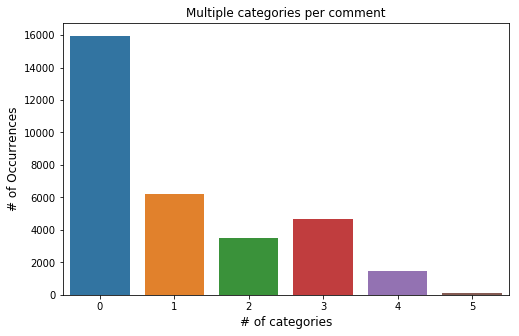

In [0]:
rowsums = undersampled_data.iloc[:,3:8].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [0]:
len(undersampled_data)

31848

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y = undersampled_data[['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
to_drop = ['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = undersampled_data.drop(to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25478, 8)
(6370, 8)
(25478, 7)
(6370, 7)


In [0]:
X_train.head()

,Unnamed: 0,comment_text,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
52068,52068,woman member brother church ( -PRON- prefer c...,280,4,0.014286,41,33,0.804878
68227,68227,: the section contain citation think question...,165,4,0.024242,31,22,0.709677
1878,1878,aaron swartz stop fuck revert goddamn edit ! !...,137,0,0.000000,31,20,0.645161
98935,98935,jim reference material marquis de lafayette a...,731,8,0.010944,119,89,0.747899
112336,112336,watch mouth dare call troll ? ugly piece shit,46,0,0.000000,9,9,1.000000


In [0]:
X_test.head()

,Unnamed: 0,comment_text,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
106593,106593,seperation article well since accordion server...,360,4,0.011111,52,40,0.769231
93921,93921,i be work reference page right now show notabi...,51,0,0.000000,9,9,1.000000
107996,107996,plus something els instead change number hazar...,338,0,0.000000,72,35,0.486111
81594,81594,unreasonable bored sick person ! reason delete...,169,4,0.023669,27,26,0.962963
123258,123258,two ugly sister land get lose two get harass s...,58,0,0.000000,11,9,0.818182


In [0]:
X_train_newfeature = X_train[new_features]

In [0]:
X_test_newfeature = X_test[new_features]

In [0]:
X_train_newfeature.head()

,Unnamed: 0,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
52068,52068,280,4,0.014286,41,33,0.804878
68227,68227,165,4,0.024242,31,22,0.709677
1878,1878,137,0,0.000000,31,20,0.645161
98935,98935,731,8,0.010944,119,89,0.747899
112336,112336,46,0,0.000000,9,9,1.000000


In [0]:
X_test_newfeature.head()

,Unnamed: 0,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
106593,106593,360,4,0.011111,52,40,0.769231
93921,93921,51,0,0.000000,9,9,1.000000
107996,107996,338,0,0.000000,72,35,0.486111
81594,81594,169,4,0.023669,27,26,0.962963
123258,123258,58,0,0.000000,11,9,0.818182


In [0]:
import scipy as sp

In [0]:
# create a sparse matrix from the DataFrame
X_train_features_sparse = sp.sparse.csr_matrix(X_train_newfeature)
type(X_train_features_sparse)

scipy.sparse.csr.csr_matrix

In [0]:
X_test_newfeature
X_test_features_sparse = sp.sparse.csr_matrix(X_test_newfeature)
type(X_test_features_sparse)

scipy.sparse.csr.csr_matrix

In [0]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train.comment_text)
X_train_dtm.shape

(25478, 5000)

In [0]:
X_train_combined = sp.sparse.hstack([X_train_dtm, X_train_features_sparse])
X_train_combined.shape

(25478, 5007)

In [0]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test.comment_text)
# examine the document-term matrix from X_test
X_test_dtm

<6370x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 106825 stored elements in Compressed Sparse Row format>

In [0]:
X_test_combined = sp.sparse.hstack([X_test_dtm, X_test_features_sparse])
X_test_combined.shape

(6370, 5007)

In [0]:
cols_target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression(C=12.0)
# submission_binary =  pd.DataFrame()

for label in cols_target:
    print('... Processing {}'.format(label))
    y_train_label = y_train[label]
    y_test_label =  y_test[label]
    
    # compute the training accuracy
    cv_socre1 = cross_val_score(logreg, X_train_combined, y_train_label, cv=5, scoring='roc_auc').mean()
    print('Training AUC is {}'.format(cv_socre1))
    
    # compute the testing accuracy
    #y_pred_test = logreg.predict(X_test_combined)
    #print('Testing accuracy is {}'.format(accuracy_score(y_test_label, y_pred_test)))
    cv_socre2 = cross_val_score(logreg, X_test_combined, y_test_label, cv=5, scoring='roc_auc').mean()
    print('Testing AUC is {}'.format(cv_socre2))

... Processing toxic
Training AUC is 0.6655898987872202
Testing AUC is 0.6530346135609293
... Processing severe_toxic
Training AUC is 0.6603696629256641
Testing AUC is 0.6511027058457103
... Processing obscene
Training AUC is 0.6089648001812178
Testing AUC is 0.6026641270080747
... Processing threat
Training AUC is 0.600672840381869
Testing AUC is 0.5883449881963991
... Processing insult
Training AUC is 0.6141379102741464
Testing AUC is 0.6176085618070829
... Processing identity_hate
Training AUC is 0.5737492433621234
Testing AUC is 0.5740751464424729
